# Problem I：Separating motif from discords

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import os
import json
import string

path = '../input/building-energy-dataset/5.data_2021.csv'
building = pd.read_csv(path, index_col="Time",parse_dates=True, header=0)

building.index = pd.to_datetime(building.index, format="%d/%m/%Y %H:%M", errors='coerce')

building.sort_index(inplace=True)

# Rename the columns for clarity
building.columns = ['HVAC_Actual_kW', 'Chiller Power [kW]', 'Humidifier power [kW]', 'HV light Power [kW]',
                    'HV power [kW]', 'PV panels power [kW]', 'Battery system power']

# Resample the dataset at an hourly resolution by summing values within each hour
building = building.resample('H').sum()

building

HVAC_Actual_kW  Chiller Power [kW]  \
Time                                                      
2021-01-01 00:00:00          53.937               8.681   
2021-01-01 01:00:00          54.041               8.717   
2021-01-01 02:00:00          53.816               8.665   
2021-01-01 03:00:00          53.573               8.588   
2021-01-01 04:00:00          53.940               8.628   
...                             ...                 ...   
2021-12-31 19:00:00          52.349               8.748   
2021-12-31 20:00:00          56.606               8.792   
2021-12-31 21:00:00          56.360               8.751   
2021-12-31 22:00:00          56.195               8.652   
2021-12-31 23:00:00          56.020               8.711   

                     Humidifier power [kW]  HV light Power [kW]  \
Time                                                              
2021-01-01 00:00:00                  0.580               25.129   
2021-01-01 01:00:00                  0.557               25.086   
2021-01-01 02:00:00                  0.551               24.921   
2021-01-01 03:00:00                  0.529               24.681   
2021-01-01 04:00:00                  0.575               24.852   
...                                    ...                  ...   
2021-12-31 19:00:00                  0.437               22.883   
2021-12-31 20:00:00                  0.423               22.670   
2021-12-31 21:00:00                  0.452               22.800   
2021-12-31 22:00:00                  0.472               22.774   
2021-12-31 23:00:00                  0.469               22.647   

                     HV power [kW]  PV panels power [kW]  Battery system power  
Time                                                                            
2021-01-01 00:00:00         153.95                 0.411                 0.070  
2021-01-01 01:00:00         121.27                 0.420                 0.064  
2021-01-01 02:00:00         127.24                 0.413                 0.065  
2021-01-01 03:00:00         126.32                 0.412                 0.067  
2021-01-01 04:00:00         148.32                 0.417                 0.079  
...                            ...                   ...                   ...  
2021-12-31 19:00:00         131.46                 0.375                 0.061  
2021-12-31 20:00:00         139.91                 0.355                 0.052  
2021-12-31 21:00:00         133.67                 0.353                 0.056  
2021-12-31 22:00:00         163.18                 0.371                 0.046  
2021-12-31 23:00:00         131.33                 0.376                 0.056  

[8760 rows x 7 columns]

In [2]:
import pandas as pd
building['Hour'] = building.index.hour

building_pivot = building.pivot_table(index=building.index.date, columns='Hour', values='HVAC_Actual_kW', aggfunc='sum')
building_pivot.columns = [f'Hour_{hour}' for hour in building_pivot.columns]
building_pivot.reset_index(inplace=True)



In [3]:
building_daily = building.resample('D').sum()
building_daily

HVAC_Actual_kW  Chiller Power [kW]  Humidifier power [kW]  \
Time                                                                    
2021-01-01        1151.769             207.722                 13.693   
2021-01-02        1370.223             208.548                 13.417   
2021-01-03        1426.405             207.599                 13.316   
2021-01-04        7531.454             208.435                 13.748   
2021-01-05        7489.048             207.848                 13.046   
...                    ...                 ...                    ...   
2021-12-27        5542.538             208.098                 12.636   
2021-12-28        5515.421             208.222                 13.298   
2021-12-29        5220.272             208.310                 11.300   
2021-12-30        5356.842             207.895                 13.462   
2021-12-31        5317.815             209.079                 12.658   

            HV light Power [kW]  HV power [kW]  PV panels power [kW]  \
Time                                                                   
2021-01-01              603.112        2287.00              -772.505   
2021-01-02              516.769        3003.05              -255.569   
2021-01-03              518.763        3173.85              -112.624   
2021-01-04             5234.710       11030.59              -102.293   
2021-01-05             5541.556       15426.20              -139.778   
...                         ...            ...                   ...   
2021-12-27             1845.830       12026.74              -364.546   
2021-12-28             2100.022        7623.66              -295.319   
2021-12-29             1530.878        8406.47              -184.244   
2021-12-30             1501.632        7164.88              -308.659   
2021-12-31              544.218        6962.27              -380.296   

            Battery system power  Hour  
Time                                    
2021-01-01                 1.746   276  
2021-01-02                 1.799   276  
2021-01-03                 1.825   276  
2021-01-04                 1.468   276  
2021-01-05                 1.523   276  
...                          ...   ...  
2021-12-27                 1.115   276  
2021-12-28                 1.080   276  
2021-12-29                 1.127   276  
2021-12-30                 1.140   276  
2021-12-31                 1.276   276  

[365 rows x 8 columns]

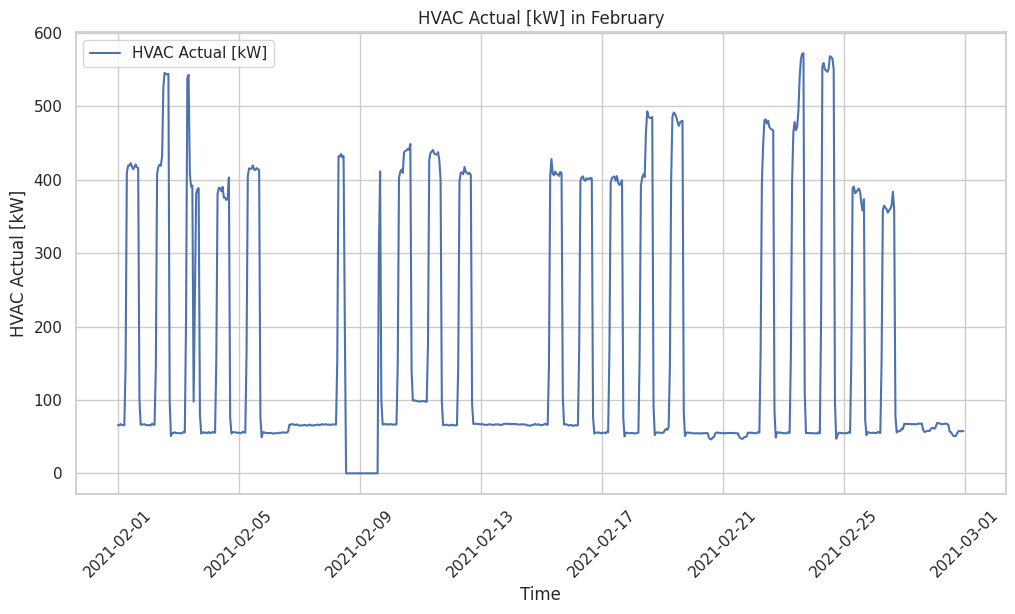

In [4]:
import seaborn as sns

# Set the style for the plot
sns.set(style="whitegrid")

# Filter data for February
building_feb = building['2021-02-01':'2021-02-28']

# Create a line plot for 'HVAC Actual [kW]'
plt.figure(figsize=(12, 6))  # Set the figure size
sns.lineplot(x=building_feb.index, y=building_feb['HVAC_Actual_kW'], color='b', label='HVAC Actual [kW]')

# Customize the plot
plt.title('HVAC Actual [kW] in February')
plt.xlabel('Time')
plt.ylabel('HVAC Actual [kW]')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the legend
plt.legend()

# Show the plot
plt.show()


## 1.SAX  transformation 

We need a function from the [Scipy](http://www.scipy.org/) library to do the SAX transformation:

In [5]:
!pip install saxpy
from scipy.stats import norm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.0/179.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 12.5 MB/s eta 0:00:00
  Created wheel for saxpy: filename=saxpy-1.0.1.dev167-py3-none-any.whl size=17688 sha256=fb91491c6f198fb088c5d9cebea92580208b0b4058855857bb955c1f6d5b9692
  Stored in directory: /root/.cache/pip/wheels/d4/06/c3/f226109b89f615fa451878c3fb8f37110889e575343fc04891
Successfully built saxpy


In [6]:
df = building["HVAC_Actual_kW"].truncate(before='2021-01-01').dropna()
df.head()

Time
2021-01-01 00:00:00    53.937
2021-01-01 01:00:00    54.041
2021-01-01 02:00:00    53.816
2021-01-01 03:00:00    53.573
2021-01-01 04:00:00    53.940
Freq: H, Name: HVAC_Actual_kW, dtype: float64

In [7]:
df_daily=df.resample('D').sum()
df_daily.head()

Time
2021-01-01    1151.769
2021-01-02    1370.223
2021-01-03    1426.405
2021-01-04    7531.454
2021-01-05    7489.048
Freq: D, Name: HVAC_Actual_kW, dtype: float64

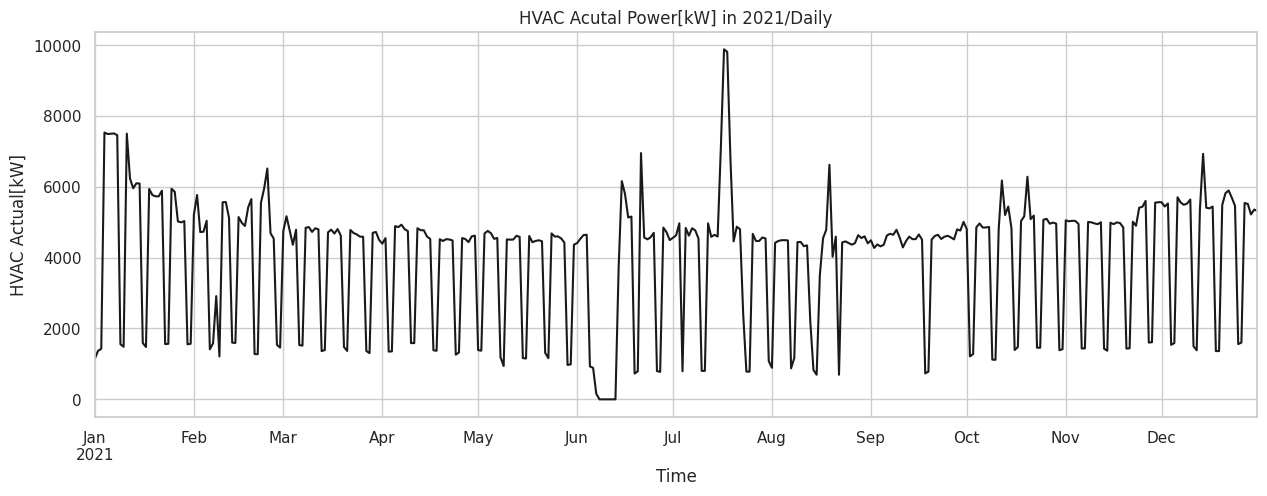

In [8]:
df_daily.plot(c='k', figsize=(15,5))
plt.title("HVAC Acutal Power[kW] in 2021/Daily")
plt.xlabel("Time")
plt.ylabel("HVAC Actual[kW]")
plt.savefig("HVACActual.png")

Let's zoom into a month and aggregate to hourly data to smooth and get a closer look at the behaviour of the plant

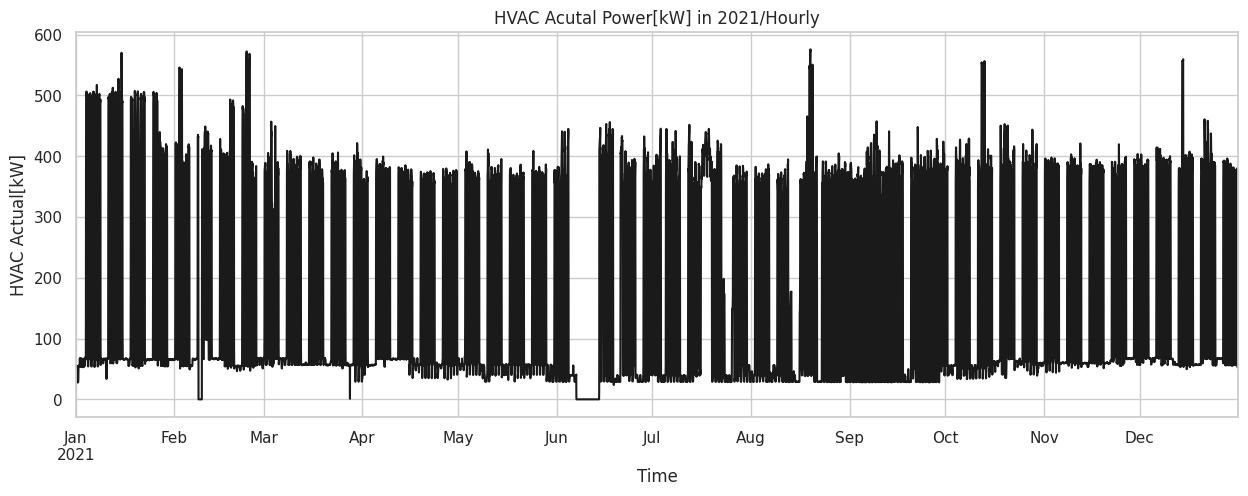

In [9]:
df.plot(c='k', figsize=(15,5))
plt.title("HVAC Acutal Power[kW] in 2021/Hourly")
plt.xlabel("Time")
plt.ylabel("HVAC Actual[kW]")
plt.savefig("HVACActual_hourly.png")

## Symbolic Aggregate ApproXimation (SAX) Transformation

To understand the typical daily profiles, we first use a very simple time-series approximation transformation step called [SAX](http://www.cs.ucr.edu/~eamonn/SAX.htm). You can read in [our paper](https://www.researchgate.net/publication/266616977_Automated_daily_pattern_filtering_of_measured_building_performance_data) all of the detail about the *how* and *why*. Here we will simply show how its calculated.

First, we set the alphabet size, $a$, and the number of window, $w$ parameters for the algorithm. The default is 3 and 4 respectively. The $w$ parameter is defined here by the lenth of the subsequence window -- in this case, 6 hours.

### Parameters 1: a=3,w=4(6h)

In [10]:
a = 3
w = '6h'

In [11]:
from saxpy.alphabet import cuts_for_asize
from saxpy.znorm import znorm
from saxpy.sax import ts_to_string
import numpy as np

input_array = np.array([-2, 0, 2, 0, -1])
input_array_normalized = znorm(input_array)
alphabet_size = 3

ts_to_string(input_array_normalized, 
             cuts_for_asize(alphabet_size))

'abcba'

In [12]:
selected_feature = 'HVAC_Actual_kW' #np array

input_array = building[selected_feature]
input_array_normalized = znorm(input_array)
alphabet_size = 3

ts_to_string(input_array_normalized, 
             cuts_for_asize(alphabet_size))


'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaccccccccccccccbaaaaaaaaaccccccccccccccaaaaaaaaaaccccccccccccccbaaaaaaaaaccccccccccccccbaaaaaaaaaccccccccccccccbaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaccccccccccccccbaaaaaaaaaacccccccccccaaaaaaaaaaaaabccccccccccaaaaaaaaaaaaabccccccccccbaaaaaaaaaaaabccccccccccbaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaabccccccccccbaaaaaaaaaaaabccccccccccaaaaaaaaaaaaabccccccccccaaaaaaaaaaaaabccccccccccaaaaaaaaaaaaabccccccccccaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaabccccccccccbaaaaaaaaaaaabccccccccccaaaaaaaaaaaaabccccccccccaaaaaaaaaaaaabccccccccccaaaaaaaaaaaaabccccccccccaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaabccccccccccbaaaaaaaaaaaabccccccccccbaaaaaaaaaaaabcccccbccccaaaaaaaaaaaaabccccccccccaaaaaaaaaaaaabccccccccccaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaabcccccbaaaaaaaaaaaaaaaaaaaaaaaaaaccbaaaaaaaaaaaabccccccccccbbbbbbbbbbbbbbcccccccc

In [13]:
# Here we reshape the SAX data with the reshape function
total_number_of_days = int(len(building.index)/24)
sax_data = building[selected_feature].values.reshape(24, total_number_of_days, order="F")
sax_data = np.transpose(sax_data)
sax_data

array([[53.937, 54.041, 53.816, ..., 53.521, 55.686, 54.548],
       [54.99 , 55.051, 54.279, ..., 61.411, 64.613, 53.774],
       [53.815, 60.743, 64.986, ..., 57.547, 63.702, 66.272],
       ...,
       [56.456, 56.295, 56.191, ..., 56.739, 56.475, 56.677],
       [56.813, 56.05 , 56.059, ..., 56.965, 56.488, 56.733],
       [56.846, 56.133, 56.471, ..., 56.36 , 56.195, 56.02 ]])

In [14]:
# Add a new column 'day' to the DataFrame representing the day of the year
building['day'] = building.index.dayofyear

# Add a new column 'hour' to the DataFrame representing the hour of the day
building['hour'] = building.index.hour

# Create a pivot table with days as index, hours as columns, and summing the 'HVAC Actual [kW]' values
sax_data = building.pivot_table(index=['day'], columns=['hour'], values=['HVAC_Actual_kW'], aggfunc='sum')

# Extract the values from the pivot table to get a 2D array
sax_data = sax_data.values
sax_data

array([[53.937, 54.041, 53.816, ..., 53.521, 55.686, 54.548],
       [54.99 , 55.051, 54.279, ..., 61.411, 64.613, 53.774],
       [53.815, 60.743, 64.986, ..., 57.547, 63.702, 66.272],
       ...,
       [56.456, 56.295, 56.191, ..., 56.739, 56.475, 56.677],
       [56.813, 56.05 , 56.059, ..., 56.965, 56.488, 56.733],
       [56.846, 56.133, 56.471, ..., 56.36 , 56.195, 56.02 ]])

Therefore we need to aggregate the time-series into smaller chuncks to reduce its dimensionality. Lets use the piecewise aggregate approximation function of the library for that.



In [15]:
# Importing necessary functions from the saxpy library
from saxpy.znorm import znorm
from saxpy.paa import paa
from saxpy.sax import ts_to_string

# Setting parameters for SAX representation
day_number_of_pieces = 4  # Number of pieces to represent each day
alphabet_size = 3  # Size of the alphabet for SAX representation

# Initializing an empty list to store daily SAX representations
all_daily_sax = []

# Looping over each row in sax_data (assuming sax_data is a 2D array or DataFrame)
for i in range(sax_data.shape[0]):
    # Normalizing the time series data using znorm
    dat_znorm = znorm(sax_data[i])
    
    # Reducing the dimensionality of the time series using PAA (Piecewise Aggregate Approximation)
    dat_paa = paa(dat_znorm, day_number_of_pieces)
    
    # Converting the reduced time series to a SAX string representation
    # using the specified alphabet size and cuts_for_asize function
    sax_string = ts_to_string(dat_paa, cuts_for_asize(alphabet_size))
    
    # Appending the SAX representation of the current day to the list
    all_daily_sax.append(sax_string)

# Displaying or returning the list of all daily SAX representations
all_daily_sax

['ccab',
 'abbc',
 'bbbb',
 'acca',
 'acca',
 'acca',
 'acca',
 'acca',
 'bbac',
 'bbac',
 'acca',
 'acca',
 'acca',
 'acca',
 'acca',
 'aacc',
 'ccaa',
 'acca',
 'acca',
 'acca',
 'acca',
 'acca',
 'abbc',
 'abbc',
 'acca',
 'acca',
 'acca',
 'acca',
 'acca',
 'abbc',
 'bbac',
 'acca',
 'acca',
 'acba',
 'acca',
 'acca',
 'aabc',
 'aabc',
 'bcaa',
 'aacb',
 'acca',
 'acca',
 'acca',
 'bbac',
 'cbab',
 'acca',
 'acca',
 'acca',
 'acca',
 'acca',
 'bcac',
 'ccab',
 'acca',
 'acca',
 'acca',
 'acca',
 'acca',
 'ccba',
 'ccaa',
 'acca',
 'acca',
 'acca',
 'acca',
 'acca',
 'ccab',
 'ccab',
 'acca',
 'acca',
 'acca',
 'acca',
 'acca',
 'abbc',
 'bcaa',
 'acca',
 'acca',
 'acca',
 'acca',
 'acca',
 'ccaa',
 'abbc',
 'acca',
 'acca',
 'acca',
 'acca',
 'acca',
 'acab',
 'abbb',
 'acca',
 'acca',
 'acca',
 'acca',
 'acca',
 'babc',
 'bacc',
 'acca',
 'acca',
 'acca',
 'acca',
 'acca',
 'aacc',
 'bcab',
 'acca',
 'acca',
 'acca',
 'acca',
 'acca',
 'bcaa',
 'ccaa',
 'acca',
 'acca',
 'acca',
 

In [16]:
# Setting parameters for SAX representation
day_number_of_pieces = 4  # Number of pieces to represent each day
alphabet_size = 3  # Size of the alphabet for SAX representation

# Initializing an empty list to store daily SAX representations
all_daily_sax = []

# Looping over each row in sax_data (assuming sax_data is a 2D array or DataFrame)
for i in range(sax_data.shape[0]):
    # Normalizing the time series data using znorm
    dat_znorm = znorm(sax_data[i])
    
    # Reducing the dimensionality of the time series using PAA (Piecewise Aggregate Approximation)
    dat_paa = paa(dat_znorm, day_number_of_pieces)
    
    # Converting the reduced time series to a SAX string representation
    # using the specified alphabet size and cuts_for_asize function
    sax_string = ts_to_string(dat_paa, cuts_for_asize(alphabet_size))
    
    # Appending the SAX representation of the current day to the list
    all_daily_sax.append(sax_string)

# The resulting list contains daily SAX representations for the entire year
print(all_daily_sax)


['ccab', 'abbc', 'bbbb', 'acca', 'acca', 'acca', 'acca', 'acca', 'bbac', 'bbac', 'acca', 'acca', 'acca', 'acca', 'acca', 'aacc', 'ccaa', 'acca', 'acca', 'acca', 'acca', 'acca', 'abbc', 'abbc', 'acca', 'acca', 'acca', 'acca', 'acca', 'abbc', 'bbac', 'acca', 'acca', 'acba', 'acca', 'acca', 'aabc', 'aabc', 'bcaa', 'aacb', 'acca', 'acca', 'acca', 'bbac', 'cbab', 'acca', 'acca', 'acca', 'acca', 'acca', 'bcac', 'ccab', 'acca', 'acca', 'acca', 'acca', 'acca', 'ccba', 'ccaa', 'acca', 'acca', 'acca', 'acca', 'acca', 'ccab', 'ccab', 'acca', 'acca', 'acca', 'acca', 'acca', 'abbc', 'bcaa', 'acca', 'acca', 'acca', 'acca', 'acca', 'ccaa', 'abbc', 'acca', 'acca', 'acca', 'acca', 'acca', 'acab', 'abbb', 'acca', 'acca', 'acca', 'acca', 'acca', 'babc', 'bacc', 'acca', 'acca', 'acca', 'acca', 'acca', 'aacc', 'bcab', 'acca', 'acca', 'acca', 'acca', 'acca', 'bcaa', 'ccaa', 'acca', 'acca', 'acca', 'acca', 'acca', 'ccab', 'ccab', 'acca', 'acca', 'acca', 'acca', 'acca', 'ccaa', 'bcba', 'acca', 'acca', 'acca',

In [17]:
df

Time
2021-01-01 00:00:00    53.937
2021-01-01 01:00:00    54.041
2021-01-01 02:00:00    53.816
2021-01-01 03:00:00    53.573
2021-01-01 04:00:00    53.940
                        ...  
2021-12-31 19:00:00    52.349
2021-12-31 20:00:00    56.606
2021-12-31 21:00:00    56.360
2021-12-31 22:00:00    56.195
2021-12-31 23:00:00    56.020
Freq: H, Name: HVAC_Actual_kW, Length: 8760, dtype: float64

In [18]:
len(df_daily)

365

In [19]:
SAXstrings = pd.DataFrame({'Time': df_daily.index, 'SAX': all_daily_sax})
SAXstrings

Time   SAX
0   2021-01-01  ccab
1   2021-01-02  abbc
2   2021-01-03  bbbb
3   2021-01-04  acca
4   2021-01-05  acca
..         ...   ...
360 2021-12-27  acca
361 2021-12-28  acca
362 2021-12-29  acca
363 2021-12-30  acca
364 2021-12-31  acca

[365 rows x 2 columns]

Now we define a few functions that will convert time series to SAX -- please note that this is a very simplifed implementation of SAX and only works with non-moving chunked daily profiles.

In [20]:
def discretizer(row, breakpoints):
    return np.where(breakpoints > float(row))[0][0]

def stringizer(row):
    return ''.join(string.ascii_letters[int(row['step'])])

def adddate(df):
    df['Date'] = df.index.map(lambda t: t.date())
    df['Time'] = df.index.map(lambda t: t.time())
    return df

def SAXizer(df, symbol_count, breakfreq):
    x = df.fillna(method='ffill')
    y = (x - x.mean()) / x.std()
    z = pd.DataFrame(y.resample(breakfreq).mean().dropna())
    z.columns = ["numbers"]
    breakpoints = norm.ppf(np.linspace(1./symbol_count, 1-1./symbol_count, symbol_count-1))
    breakpoints = np.concatenate((breakpoints, np.array([np.Inf])))
    
    z['step'] = z.apply(discretizer, axis=1, args=[breakpoints])
    z['letter'] = z.apply(stringizer, axis=1)
    z = adddate(z)
    zpivot = z.pivot(index='Date', columns='Time', values='letter')
    zpivot = z.pivot(index='Date', columns='Time', values='letter')
    
    SAXstrings = zpivot.dropna().sum(axis=1)
    
    return zpivot.dropna(), SAXstrings

Let's feed out `df` into these functions and get the SAX word patterns out

In [21]:
SAXstrings.head(15)

Time   SAX
0  2021-01-01  ccab
1  2021-01-02  abbc
2  2021-01-03  bbbb
3  2021-01-04  acca
4  2021-01-05  acca
5  2021-01-06  acca
6  2021-01-07  acca
7  2021-01-08  acca
8  2021-01-09  bbac
9  2021-01-10  bbac
10 2021-01-11  acca
11 2021-01-12  acca
12 2021-01-13  acca
13 2021-01-14  acca
14 2021-01-15  acca

In [22]:
patterncount = SAXstrings['SAX'].value_counts()
patterncount

SAX
acca    254
ccaa     13
ccab     10
abbc      9
bbbb      7
cbaa      7
aabc      6
bbac      5
aacc      5
bcaa      5
babc      4
bcca      4
bacc      3
ccba      3
acac      2
bcac      2
bcab      2
cbab      2
acaa      2
abca      2
bbbc      1
abcc      1
cabb      1
babb      1
abcb      1
bacb      1
cbac      1
bcba      1
bbba      1
acbb      1
caaa      1
bbab      1
cbba      1
abbb      1
acab      1
aacb      1
acba      1
accc      1
Name: count, dtype: int64

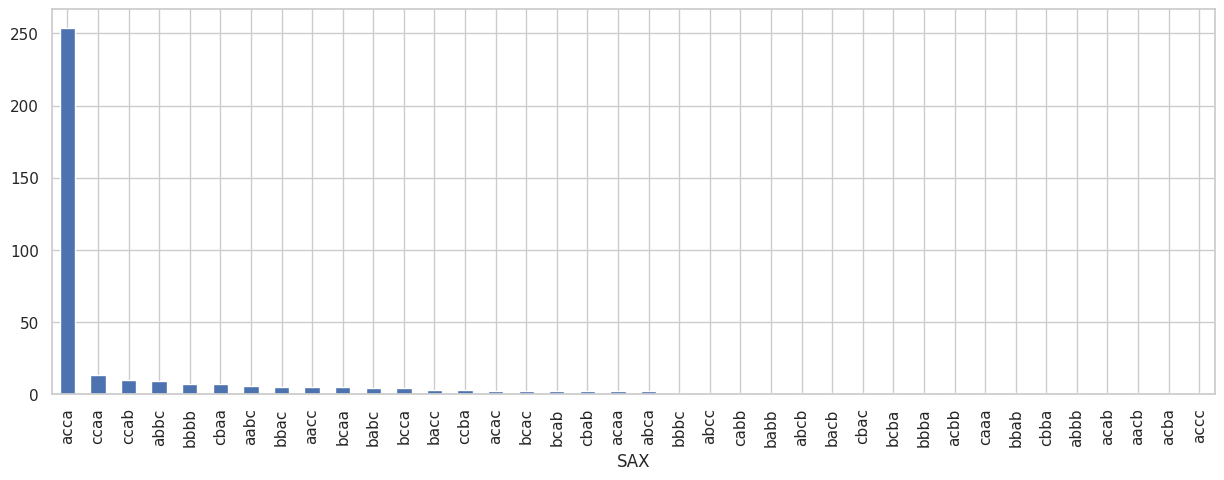

In [23]:
patterncount.plot(kind='bar', figsize=(15,5));
plt.savefig('Barplot.png')

## Parameters 2: a=4,w=4(6h)

In [24]:
from saxpy.alphabet import cuts_for_asize
from saxpy.znorm import znorm
from saxpy.sax import ts_to_string
import numpy as np

input_array = np.array([-2, 0, 2, 0, -1])
input_array_normalized = znorm(input_array)
alphabet_size_4 = 4

ts_to_string(input_array_normalized, 
             cuts_for_asize(alphabet_size_4))

selected_feature = 'HVAC_Actual_kW' #np array

input_array = building[selected_feature]
input_array_normalized = znorm(input_array)
alphabet_size_4 = 4

ts_to_string(input_array_normalized, 
             cuts_for_asize(alphabet_size_4))

'aaaaaaaaaaaaaaaaaaaaaabaaaaaaabbaaaaabbaabbaabbaabbaabbaabbaabbabbabbbbbbbbbbddddddddddddddbaaabbbbbbddddddddddddddbaaaaabbbbddddddddddddddbaaaaabbbbddddddddddddddbaaaaabbbbddddddddddddddbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbaaaabbbbbbbbbbbddddddddddddddbbbbbbbbbbbdddddddddddbbbbbbbbbbbbbcddddddddddbbbbbbbbbbbbbcddddddddddbbbbbbbbbbbbbcddddddddddbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbabbbbbbbbbbbbbbcddddddddddbbbbbbbaaaaaacddddddddddbabbbbaababbbcddddddddddbaabbaabbaaaacddddddddddbbbbbabbbbbbbbddddddddddbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbddddddddddbbbbbbbbbbbbbbddddddddddbabbbbbbbbbbbbddddddddddbabbbbaaabbaabddddddddddbaabaaaaaaabbcddddddddddbaabaaaabbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbddddddddddbbbbbbbbbbbbbbddddddddddbaaabaaaaaabbcdddddbcdddbaabaaabaabbabddddddddddbabbbaaaaabbabddddddddddbabbaaaaaaaaaaaaabbababbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbdddddcaaaaaaaaaaaaaaaaaaaaaaaaaaddbbbbbbbbbbbbbbddddddddddbbbbbbbbbbbbbcdddddddd

In [25]:


# Setting parameters for SAX representation
day_number_of_pieces = 4  # Number of pieces to represent each day
alphabet_size_4 = 4  # Size of the alphabet for SAX representation

# Initializing an empty list to store daily SAX representations
all_daily_sax_4 = []

# Looping over each row in sax_data (assuming sax_data is a 2D array or DataFrame)
for i in range(sax_data.shape[0]):
    # Normalizing the time series data using znorm
    dat_znorm_4 = znorm(sax_data[i])
    
    # Reducing the dimensionality of the time series using PAA (Piecewise Aggregate Approximation)
    dat_paa_4 = paa(dat_znorm_4, day_number_of_pieces)
    
    # Converting the reduced time series to a SAX string representation
    # using the specified alphabet size and cuts_for_asize function
    sax_string_4 = ts_to_string(dat_paa_4, cuts_for_asize(alphabet_size_4))
    
    # Appending the SAX representation of the current day to the list
    all_daily_sax_4.append(sax_string_4)

# Displaying or returning the list of all daily SAX representations
all_daily_sax_4


['ccab',
 'bbcc',
 'bbcc',
 'adda',
 'adda',
 'adda',
 'adda',
 'adda',
 'ccad',
 'ccac',
 'adda',
 'adda',
 'adda',
 'adda',
 'adda',
 'badc',
 'ddab',
 'adda',
 'adda',
 'adda',
 'adda',
 'adda',
 'abcd',
 'acbd',
 'adda',
 'adda',
 'adda',
 'adda',
 'adda',
 'accc',
 'bbbd',
 'adda',
 'acda',
 'adca',
 'adda',
 'adda',
 'aacd',
 'abcd',
 'bdba',
 'bbdc',
 'adda',
 'adda',
 'adda',
 'bbbd',
 'dcac',
 'adda',
 'adda',
 'adda',
 'adda',
 'adda',
 'ccac',
 'ccac',
 'adda',
 'adda',
 'adda',
 'adda',
 'adda',
 'ddba',
 'ddab',
 'adda',
 'addb',
 'adca',
 'adda',
 'adda',
 'ccac',
 'ddab',
 'adda',
 'adda',
 'adda',
 'adda',
 'adda',
 'acbd',
 'cdbb',
 'adda',
 'adda',
 'adda',
 'adda',
 'adda',
 'ddaa',
 'abcd',
 'adda',
 'adda',
 'adda',
 'adda',
 'adda',
 'bdbc',
 'bccc',
 'adda',
 'adda',
 'adda',
 'adda',
 'adda',
 'bacd',
 'bacd',
 'adda',
 'adda',
 'adda',
 'adda',
 'adda',
 'aadc',
 'ccac',
 'adda',
 'adda',
 'adda',
 'adda',
 'adda',
 'cdab',
 'cdab',
 'adda',
 'adda',
 'adda',
 

In [26]:
from collections import Counter

# Counting the occurrences of each unique SAX representation
counts_4 = Counter(all_daily_sax_4)

# Displaying the counts
print(counts_4)

Counter({'adda': 248, 'ccac': 8, 'cdab': 8, 'bbbb': 6, 'ddab': 5, 'bacd': 5, 'dcaa': 5, 'abcd': 4, 'acbd': 4, 'accc': 4, 'adca': 4, 'ddaa': 4, 'dcab': 4, 'bbcc': 3, 'bbbd': 3, 'ddba': 3, 'bdbb': 3, 'ccab': 2, 'badc': 2, 'acda': 2, 'aacd': 2, 'addb': 2, 'dcba': 2, 'dcca': 2, 'dcbb': 2, 'dbbb': 2, 'acdb': 2, 'ccca': 2, 'bacc': 2, 'ccad': 1, 'bdba': 1, 'bbdc': 1, 'dcac': 1, 'cdbb': 1, 'bdbc': 1, 'bccc': 1, 'aadc': 1, 'ccbb': 1, 'bdca': 1, 'bdda': 1, 'accd': 1, 'abdc': 1, 'bcda': 1, 'cbcc': 1, 'abbd': 1, 'cdba': 1, 'bcbc': 1, 'babd': 1, 'cabc': 1})


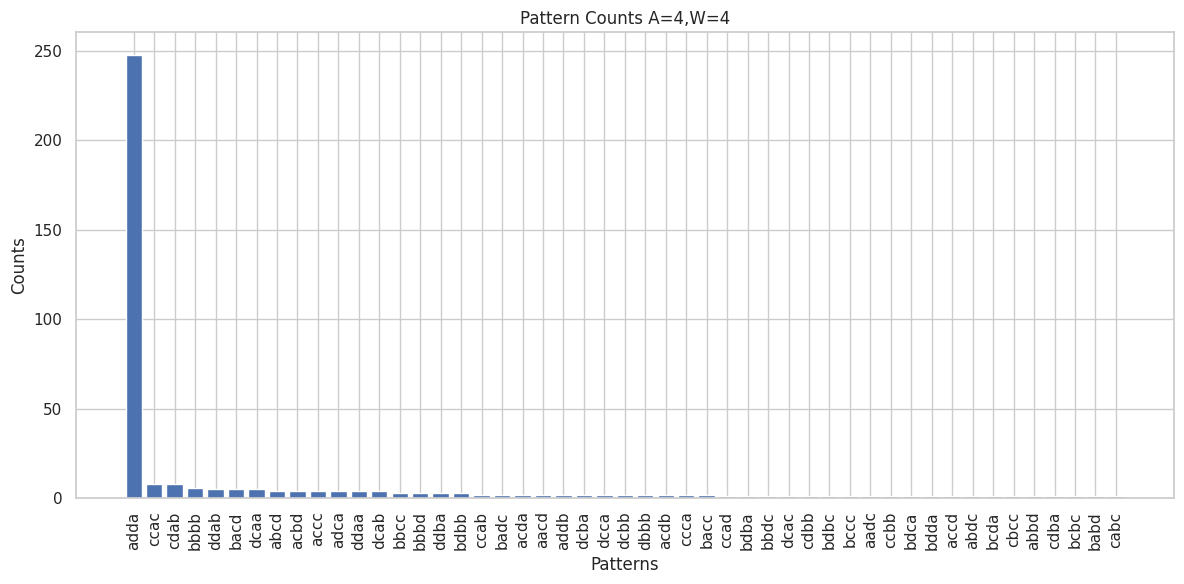

In [27]:
from collections import Counter

# Provided Counter dictionary
counts_dict_4 = {'adda': 248, 'ccac': 8, 'cdab': 8, 'bbbb': 6, 'ddab': 5, 'bacd': 5, 'dcaa': 5, 'abcd': 4, 'acbd': 4, 'accc': 4, 'adca': 4, 'ddaa': 4, 'dcab': 4, 'bbcc': 3, 'bbbd': 3, 'ddba': 3, 'bdbb': 3, 'ccab': 2, 'badc': 2, 'acda': 2, 'aacd': 2, 'addb': 2, 'dcba': 2, 'dcca': 2, 'dcbb': 2, 'dbbb': 2, 'acdb': 2, 'ccca': 2, 'bacc': 2, 'ccad': 1, 'bdba': 1, 'bbdc': 1, 'dcac': 1, 'cdbb': 1, 'bdbc': 1, 'bccc': 1, 'aadc': 1, 'ccbb': 1, 'bdca': 1, 'bdda': 1, 'accd': 1, 'abdc': 1, 'bcda': 1, 'cbcc': 1, 'abbd': 1, 'cdba': 1, 'bcbc': 1, 'babd': 1, 'cabc': 1}


# Extract patterns and count
patterns_4 = list(counts_dict_4.keys())
counts_4 = list(counts_dict_4.values())

# Create a bar plot
plt.figure(figsize=(12, 6))  
plt.bar(range(len(patterns_4)), counts_4, tick_label=patterns_4)
plt.xticks(rotation=90)  
plt.xlabel('Patterns')
plt.ylabel('Counts')
plt.title('Pattern Counts A=4,W=4')
plt.tight_layout() 
plt.savefig('Barplot_A=4W=4.png')
plt.show()

### I  choose a=3, w=4

### heatmap

In [28]:
SAXstrings.set_index('Time', inplace=True) 

In [29]:
SAXstrings

SAX
Time            
2021-01-01  ccab
2021-01-02  abbc
2021-01-03  bbbb
2021-01-04  acca
2021-01-05  acca
...          ...
2021-12-27  acca
2021-12-28  acca
2021-12-29  acca
2021-12-30  acca
2021-12-31  acca

[365 rows x 1 columns]

In [30]:

building_pivot['index'] = pd.to_datetime(building_pivot['index'])
building_pivot.set_index('index', inplace=True)


In [31]:
building_pivot['SAX'] = SAXstrings['SAX']
df_RawAndSAX = building_pivot

#df_RawAndSAX['SAX'].fillna('', inplace=True)
df_RawAndSAX

Hour_0  Hour_1  Hour_2  Hour_3  Hour_4   Hour_5   Hour_6   Hour_7  \
index                                                                           
2021-01-01  53.937  54.041  53.816  53.573  53.940   53.950   53.937   53.901   
2021-01-02  54.990  55.051  54.279  53.978  53.812   53.655   56.039   67.849   
2021-01-03  53.815  60.743  64.986  53.698  53.294   61.284   63.872   52.819   
2021-01-04  66.848  65.873  65.767  65.808  65.997  384.004  500.568  498.708   
2021-01-05  68.085  66.309  66.472  66.319  66.026  378.360  494.968  500.463   
...            ...     ...     ...     ...     ...      ...      ...      ...   
2021-12-27  66.940  65.923  66.071  63.220  59.988   59.337  352.494  391.667   
2021-12-28  55.891  56.146  56.210  56.186  55.898   56.007  354.836  392.569   
2021-12-29  56.456  56.295  56.191  56.121  56.465   56.191  350.857  385.106   
2021-12-30  56.813  56.050  56.059  56.308  56.268   55.560  349.139  381.462   
2021-12-31  56.846  56.133  56.471  56.724  56.594   56.303  338.901  377.245   

             Hour_8   Hour_9  ...  Hour_15  Hour_16  Hour_17  Hour_18  \
index                         ...                                       
2021-01-01   53.730   53.920  ...   27.562   27.895   28.061   28.205   
2021-01-02   54.502   54.973  ...   54.229   54.155   57.909   67.699   
2021-01-03   53.488   66.372  ...   53.666   60.099   66.819   54.940   
2021-01-04  500.841  506.295  ...  502.409  494.786  498.882  500.405   
2021-01-05  501.908  498.197  ...  490.624  499.012  496.802  497.380   
...             ...      ...  ...      ...      ...      ...      ...   
2021-12-27  390.016  391.411  ...  389.124  391.046  389.019  229.362   
2021-12-28  388.685  391.018  ...  391.939  389.549  392.649  233.289   
2021-12-29  384.080  384.896  ...  378.054  378.083  381.311  225.588   
2021-12-30  381.467  379.285  ...  376.628  376.721  376.050  225.457   
2021-12-31  377.847  376.480  ...  379.539  377.149  375.321  216.154   

            Hour_19  Hour_20  Hour_21  Hour_22  Hour_23   SAX  
index                                                          
2021-01-01   29.825   49.273   53.521   55.686   54.548  ccab  
2021-01-02   54.558   54.736   61.411   64.613   53.774  abbc  
2021-01-03   56.374   68.653   57.547   63.702   66.272  bbbb  
2021-01-04  101.041   54.867   55.070   54.187   56.606  acca  
2021-01-05   92.508   54.989   54.339   53.834   53.980  acca  
...             ...      ...      ...      ...      ...   ...  
2021-12-27   56.338   57.177   56.860   56.624   57.050  acca  
2021-12-28   55.917   56.686   56.966   56.930   56.698  acca  
2021-12-29   55.379   56.646   56.739   56.475   56.677  acca  
2021-12-30   57.057   56.784   56.965   56.488   56.733  acca  
2021-12-31   52.349   56.606   56.360   56.195   56.020  acca  

[365 rows x 25 columns]

In [32]:
pattern = 'acca'

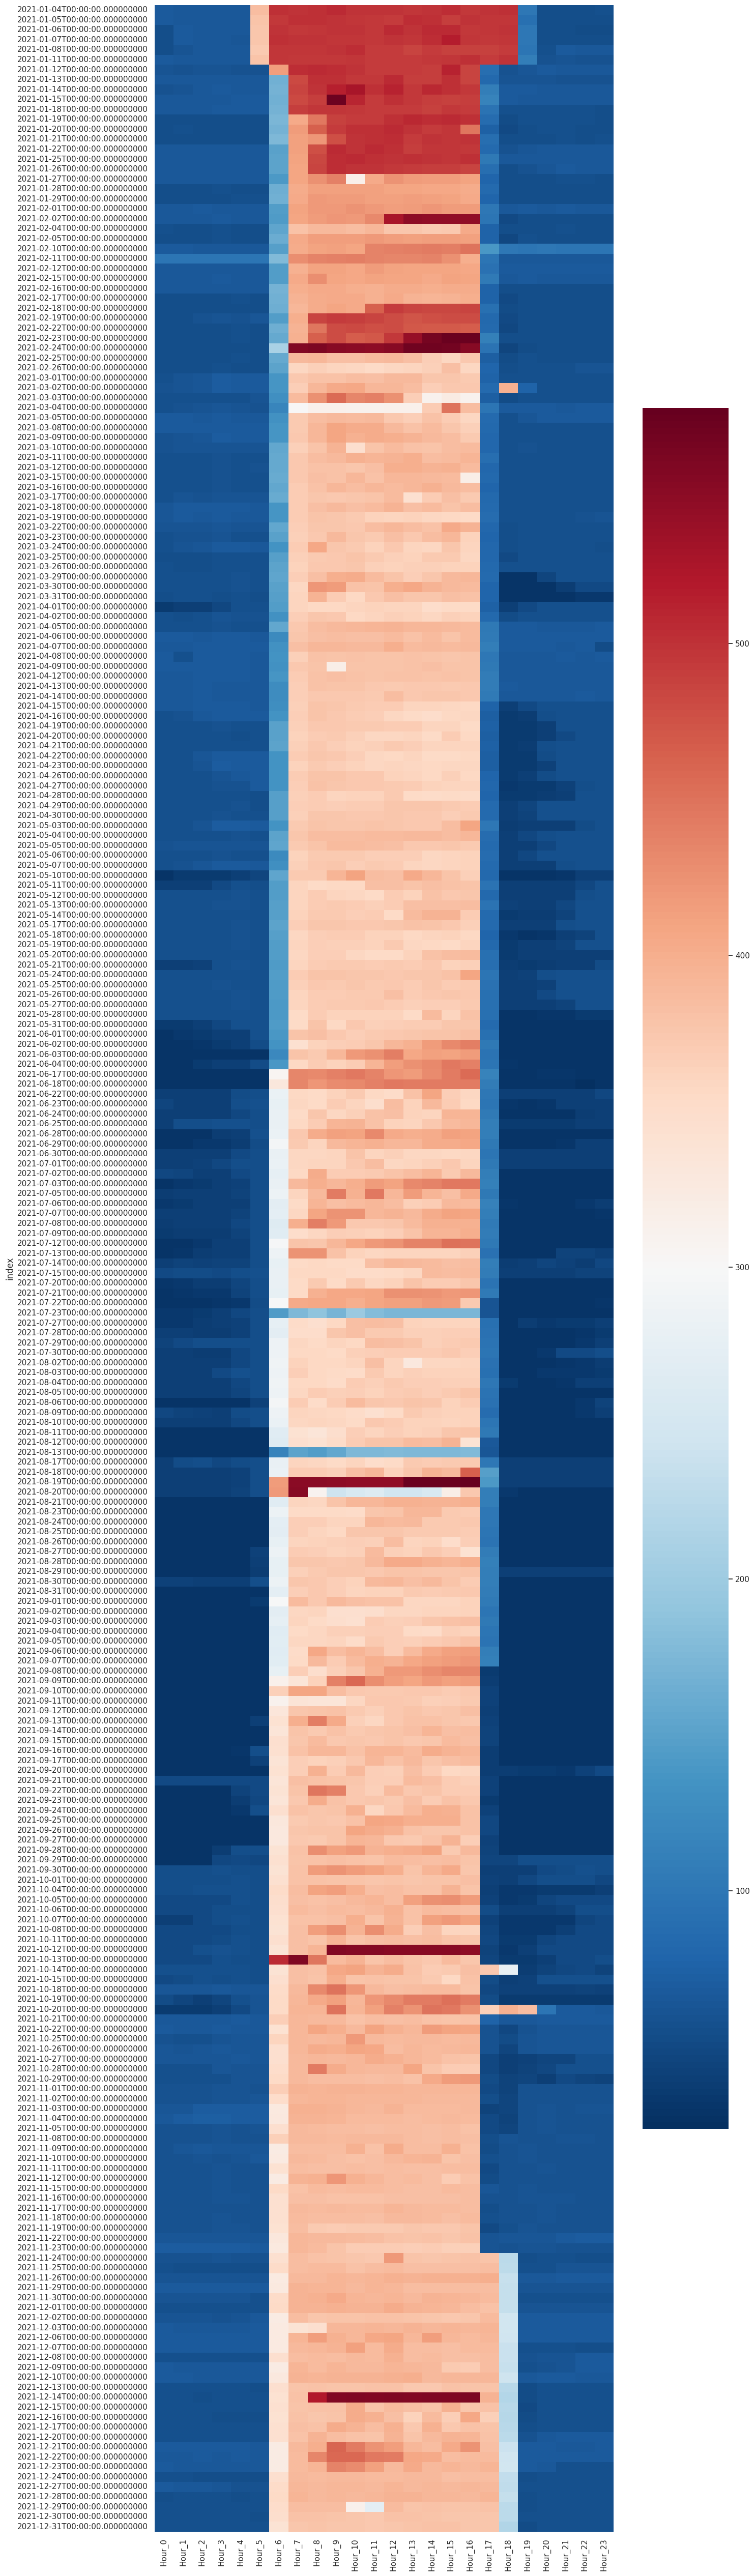

In [33]:
patterns = df_RawAndSAX[df_RawAndSAX.SAX == pattern].drop(['SAX'],axis=1)
f, ax = plt.subplots(figsize=(15, len(patterns)*0.2))
sns.heatmap(patterns,linewidths=0, cmap="RdBu_r")
f.tight_layout()
plt.savefig("HVAC_heatmap_"+pattern+".png")

## Partition patterns into motif and discord candidates

i set the thereshold as  0.01

In [34]:

binsizethreshold = 0.01

In [35]:
motifs = patterncount[(patterncount > patterncount.sum() * binsizethreshold)]
motifs

SAX
acca    254
ccaa     13
ccab     10
abbc      9
bbbb      7
cbaa      7
aabc      6
bbac      5
aacc      5
bcaa      5
babc      4
bcca      4
Name: count, dtype: int64

In [36]:
discords = patterncount[(patterncount < patterncount.sum() * binsizethreshold)]
discords

SAX
bacc    3
ccba    3
acac    2
bcac    2
bcab    2
cbab    2
acaa    2
abca    2
bbbc    1
abcc    1
cabb    1
babb    1
abcb    1
bacb    1
cbac    1
bcba    1
bbba    1
acbb    1
caaa    1
bbab    1
cbba    1
abbb    1
acab    1
aacb    1
acba    1
accc    1
Name: count, dtype: int64

#### motifs patterns

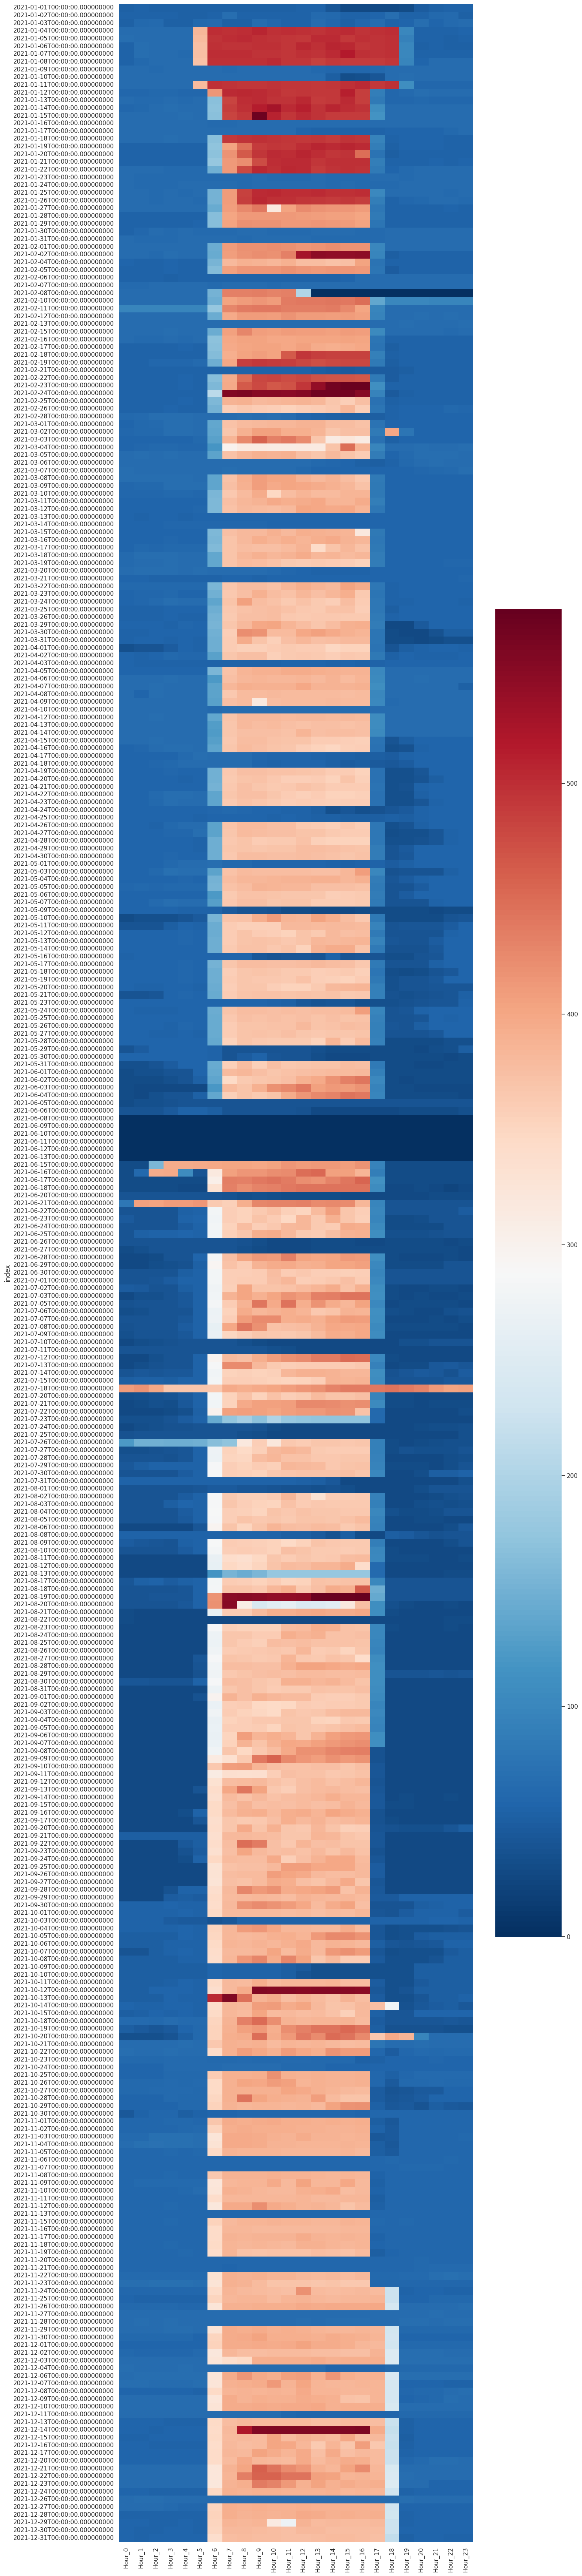

In [37]:
patterns = df_RawAndSAX[df_RawAndSAX.SAX.isin(list(motifs.index))].drop(['SAX'],axis=1)
f, ax = plt.subplots(figsize=(15, len(patterns)*0.2))
sns.heatmap(patterns, linewidths=0, cmap="RdBu_r")
f.tight_layout()
plt.savefig("_heatmap_motifs.png")

#### discord patterns

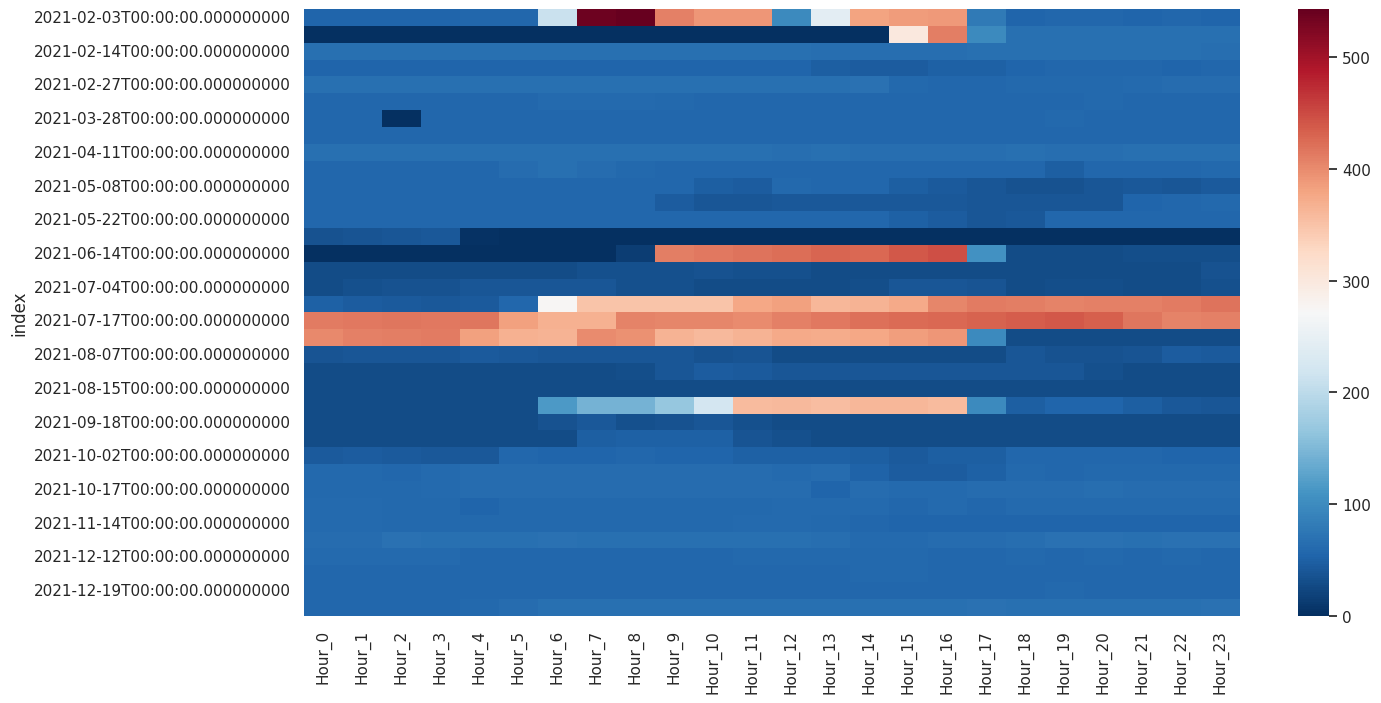

In [38]:
patterns = df_RawAndSAX[df_RawAndSAX.SAX.isin(list(discords.index))].drop(['SAX'],axis=1)
f, ax = plt.subplots(figsize=(15, len(patterns)*0.2))
sns.heatmap(patterns, linewidths=0, cmap="RdBu_r")
f.tight_layout()
plt.savefig("_heatmap_discords.png")

In [39]:
motifdata = df_RawAndSAX[df_RawAndSAX.SAX.isin(list(motifs.index))]
discorddata = df_RawAndSAX[df_RawAndSAX.SAX.isin(list(discords.index))].dropna()

In [40]:
discorddata.to_csv("DiscordProfiles.csv")
motifdata.to_csv("MotifProfiles.csv")

# Problem II: Clustering for pattern identification

Using the validity indices and method described above select the optimal number of clusters for the AHU motifs. Visually support your parameter selection with appropriate plots.

In [41]:
motifs = pd.read_csv("./MotifProfiles.csv",parse_dates=True, index_col='index')
motifs.index.name = 'Date'
motifs.head()

Hour_0  Hour_1  Hour_2  Hour_3  Hour_4   Hour_5   Hour_6   Hour_7  \
Date                                                                            
2021-01-01  53.937  54.041  53.816  53.573  53.940   53.950   53.937   53.901   
2021-01-02  54.990  55.051  54.279  53.978  53.812   53.655   56.039   67.849   
2021-01-03  53.815  60.743  64.986  53.698  53.294   61.284   63.872   52.819   
2021-01-04  66.848  65.873  65.767  65.808  65.997  384.004  500.568  498.708   
2021-01-05  68.085  66.309  66.472  66.319  66.026  378.360  494.968  500.463   

             Hour_8   Hour_9  ...  Hour_15  Hour_16  Hour_17  Hour_18  \
Date                          ...                                       
2021-01-01   53.730   53.920  ...   27.562   27.895   28.061   28.205   
2021-01-02   54.502   54.973  ...   54.229   54.155   57.909   67.699   
2021-01-03   53.488   66.372  ...   53.666   60.099   66.819   54.940   
2021-01-04  500.841  506.295  ...  502.409  494.786  498.882  500.405   
2021-01-05  501.908  498.197  ...  490.624  499.012  496.802  497.380   

            Hour_19  Hour_20  Hour_21  Hour_22  Hour_23   SAX  
Date                                                           
2021-01-01   29.825   49.273   53.521   55.686   54.548  ccab  
2021-01-02   54.558   54.736   61.411   64.613   53.774  abbc  
2021-01-03   56.374   68.653   57.547   63.702   66.272  bbbb  
2021-01-04  101.041   54.867   55.070   54.187   56.606  acca  
2021-01-05   92.508   54.989   54.339   53.834   53.980  acca  

[5 rows x 25 columns]

In [42]:
motifs = motifs.drop(['SAX'], axis=1)
# Define a list of new column names
#new_column_names = [f'00:{i:02}:00' for i in range(24)]

# Rename the columns
#motifs.columns = new_column_names
motifs = motifs.reset_index()
motifs.head()

Date  Hour_0  Hour_1  Hour_2  Hour_3  Hour_4   Hour_5   Hour_6  \
0 2021-01-01  53.937  54.041  53.816  53.573  53.940   53.950   53.937   
1 2021-01-02  54.990  55.051  54.279  53.978  53.812   53.655   56.039   
2 2021-01-03  53.815  60.743  64.986  53.698  53.294   61.284   63.872   
3 2021-01-04  66.848  65.873  65.767  65.808  65.997  384.004  500.568   
4 2021-01-05  68.085  66.309  66.472  66.319  66.026  378.360  494.968   

    Hour_7   Hour_8  ...  Hour_14  Hour_15  Hour_16  Hour_17  Hour_18  \
0   53.901   53.730  ...   41.914   27.562   27.895   28.061   28.205   
1   67.849   54.502  ...   61.987   54.229   54.155   57.909   67.699   
2   52.819   53.488  ...   60.433   53.666   60.099   66.819   54.940   
3  498.708  500.841  ...  499.446  502.409  494.786  498.882  500.405   
4  500.463  501.908  ...  502.067  490.624  499.012  496.802  497.380   

   Hour_19  Hour_20  Hour_21  Hour_22  Hour_23  
0   29.825   49.273   53.521   55.686   54.548  
1   54.558   54.736   61.411   64.613   53.774  
2   56.374   68.653   57.547   63.702   66.272  
3  101.041   54.867   55.070   54.187   56.606  
4   92.508   54.989   54.339   53.834   53.980  

[5 rows x 25 columns]

In [43]:
# Melt the DataFrame to reshape it
melted_motifs = pd.melt(motifs, id_vars='Date', var_name='Hour', value_name='Value')

# Create a function to map the Hour values to the desired format
def format_hour(hour_value):
    return f'{hour_value:02d}:00:00'

# Apply the format_hour function to the 'Hour' column
melted_motifs['Hour'] = melted_motifs['Hour'].apply(lambda x: format_hour(int(x.split('_')[1])))
melted_motifs.head()



Date      Hour   Value
0 2021-01-01  00:00:00  53.937
1 2021-01-02  00:00:00  54.990
2 2021-01-03  00:00:00  53.815
3 2021-01-04  00:00:00  66.848
4 2021-01-05  00:00:00  68.085

In [44]:
# Convert 'Date' and 'Hour' columns to strings and combine them into a single column
melted_motifs['DateTime'] = melted_motifs['Date'].astype(str) + ' ' + melted_motifs['Hour'].astype(str)

# Drop the original 'Date' and 'Hour' columns if needed
melted_motifs = melted_motifs.drop(columns=['Date', 'Hour'])

# Display the DataFrame
melted_motifs.head()



Value             DateTime
0  53.937  2021-01-01 00:00:00
1  54.990  2021-01-02 00:00:00
2  53.815  2021-01-03 00:00:00
3  66.848  2021-01-04 00:00:00
4  68.085  2021-01-05 00:00:00

In [45]:
# Set 'DateTime' column as the index
melted_motifs.set_index('DateTime', inplace=True)
melted_motifs.rename(columns={'Value': 'HVAC_Actual_kW'}, inplace=True)
melted_motifs.head()


HVAC_Actual_kW
DateTime                           
2021-01-01 00:00:00          53.937
2021-01-02 00:00:00          54.990
2021-01-03 00:00:00          53.815
2021-01-04 00:00:00          66.848
2021-01-05 00:00:00          68.085

### 2. Optimal number for clusters

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2 The average silhouette_score is: 0.6030616754629701
For n_clusters = 3 The average silhouette_score is: 0.5257734320496361


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4 The average silhouette_score is: 0.5172399907197289
For n_clusters = 5 The average silhouette_score is: 0.5122901331391301


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6 The average silhouette_score is: 0.5121877593457668


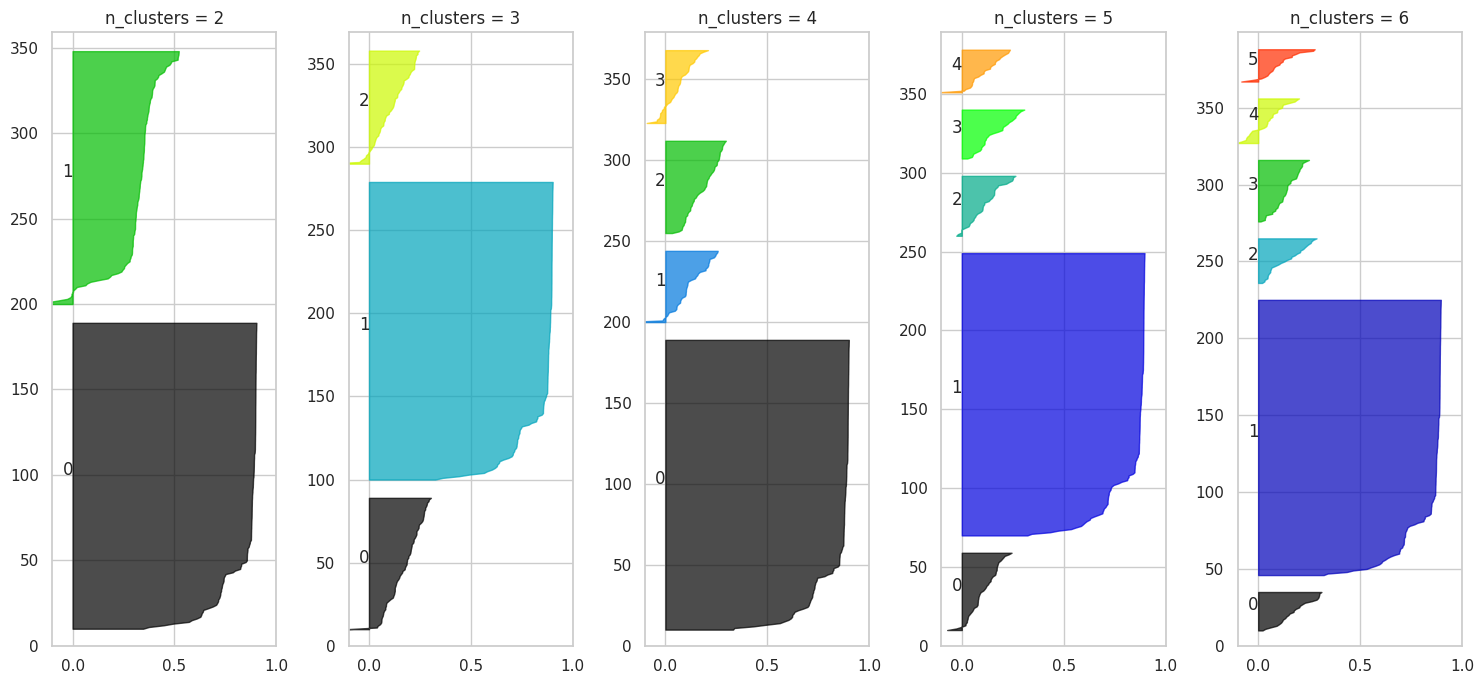

In [46]:

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
nbofdays = int(len(melted_motifs.index)/24)
X = melted_motifs['HVAC_Actual_kW'].values.reshape(24, nbofdays, order="F")
X = X.transpose()
max_number_of_clusters = 6

# Create a single figure with multiple subplots for silhouette plots
fig, axes = plt.subplots(1, max_number_of_clusters - 1, figsize=(15, 7))

for n_clusters in range(2, max_number_of_clusters + 1):
    ax1 = axes[n_clusters - 2]  # Select the corresponding subplot

    # Set the same limits and labels for each subplot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    ax1.set_title("n_clusters = %d" % n_clusters)

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is:", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

# Adjust the layout to prevent overlapping titles
plt.tight_layout()

# Save the figure with multiple subplots
plt.savefig("silhouette_plots.png")
plt.show()


normalize data before cluster

In [47]:
melted_motifs.index = pd.to_datetime(melted_motifs.index)
melted_motifs

HVAC_Actual_kW
DateTime                           
2021-01-01 00:00:00          53.937
2021-01-02 00:00:00          54.990
2021-01-03 00:00:00          53.815
2021-01-04 00:00:00          66.848
2021-01-05 00:00:00          68.085
...                             ...
2021-12-27 23:00:00          57.050
2021-12-28 23:00:00          56.698
2021-12-29 23:00:00          56.677
2021-12-30 23:00:00          56.733
2021-12-31 23:00:00          56.020

[7896 rows x 1 columns]

In [48]:
melted_motifs_norm = (melted_motifs - melted_motifs.mean()) / (melted_motifs.max() - melted_motifs.min()) #normalized

melted_motifs['Time'] = melted_motifs.index.map(lambda t: t.time())
melted_motifs['Date'] = melted_motifs.index.map(lambda t: t.date())
melted_motifs_norm['Time'] = melted_motifs_norm.index.map(lambda t: t.time())
melted_motifs_norm['Date'] = melted_motifs_norm.index.map(lambda t: t.date())

In [49]:
dailyblocks = pd.pivot_table(melted_motifs, values='HVAC_Actual_kW', index='Date', columns='Time', aggfunc='mean')
dailyblocks_norm = pd.pivot_table(melted_motifs_norm, values='HVAC_Actual_kW', index='Date', columns='Time', aggfunc='mean')

In [50]:
dailyblocks_norm.head()

Time        00:00:00  01:00:00  02:00:00  03:00:00  04:00:00  05:00:00  \
Date                                                                     
2021-01-01 -0.208649 -0.208469 -0.208860 -0.209282 -0.208644 -0.208627   
2021-01-02 -0.206820 -0.206714 -0.208055 -0.208578 -0.208867 -0.209139   
2021-01-03 -0.208861 -0.196826 -0.189455 -0.209065 -0.209766 -0.195886   
2021-01-04 -0.186220 -0.187914 -0.188098 -0.188027 -0.187699  0.364743   
2021-01-05 -0.184071 -0.187157 -0.186874 -0.187139 -0.187648  0.354938   

Time        06:00:00  07:00:00  08:00:00  09:00:00  ...  14:00:00  15:00:00  \
Date                                                ...                       
2021-01-01 -0.208649 -0.208712 -0.209009 -0.208679  ... -0.229536 -0.254468   
2021-01-02 -0.204998 -0.184481 -0.207668 -0.206850  ... -0.194665 -0.208142   
2021-01-03 -0.191390 -0.210592 -0.209429 -0.187047  ... -0.197365 -0.209120   
2021-01-04  0.567238  0.564007  0.567712  0.577187  ...  0.565289  0.570436   
2021-01-05  0.557510  0.567056  0.569566  0.563119  ...  0.569842  0.549963   

Time        16:00:00  17:00:00  18:00:00  19:00:00  20:00:00  21:00:00  \
Date                                                                     
2021-01-01 -0.253890 -0.253601 -0.253351 -0.250537 -0.216752 -0.209372   
2021-01-02 -0.208271 -0.201749 -0.184742 -0.207571 -0.207261 -0.195666   
2021-01-03 -0.197945 -0.186271 -0.206907 -0.204416 -0.183085 -0.202378   
2021-01-04  0.557193  0.564309  0.566955 -0.126820 -0.207034 -0.206681   
2021-01-05  0.564535  0.560696  0.561700 -0.141644 -0.206822 -0.207951   

Time        22:00:00  23:00:00  
Date                            
2021-01-01 -0.205611 -0.207588  
2021-01-02 -0.190103 -0.208933  
2021-01-03 -0.191686 -0.187221  
2021-01-04 -0.208215 -0.204013  
2021-01-05 -0.208828 -0.208575  

[5 rows x 24 columns]

In [51]:
from scipy.cluster.vq import kmeans, vq, whiten
from scipy.spatial.distance import cdist
from sklearn import metrics
import numpy as np
dailyblocksmatrix_norm = np.matrix(dailyblocks_norm.dropna())
centers, _ = kmeans(dailyblocksmatrix_norm, 4, iter=10000)
cluster, _ = vq(dailyblocksmatrix_norm, centers)

In [52]:
clusterdf = pd.DataFrame(cluster, columns=['ClusterNo'])

In [53]:
dailyclusters = pd.concat([dailyblocks.dropna().reset_index(), clusterdf], axis=1) 
dailyclusters.head()

Date  00:00:00  01:00:00  02:00:00  03:00:00  04:00:00  05:00:00  \
0  2021-01-01    53.937    54.041    53.816    53.573    53.940    53.950   
1  2021-01-02    54.990    55.051    54.279    53.978    53.812    53.655   
2  2021-01-03    53.815    60.743    64.986    53.698    53.294    61.284   
3  2021-01-04    66.848    65.873    65.767    65.808    65.997   384.004   
4  2021-01-05    68.085    66.309    66.472    66.319    66.026   378.360   

   06:00:00  07:00:00  08:00:00  ...  15:00:00  16:00:00  17:00:00  18:00:00  \
0    53.937    53.901    53.730  ...    27.562    27.895    28.061    28.205   
1    56.039    67.849    54.502  ...    54.229    54.155    57.909    67.699   
2    63.872    52.819    53.488  ...    53.666    60.099    66.819    54.940   
3   500.568   498.708   500.841  ...   502.409   494.786   498.882   500.405   
4   494.968   500.463   501.908  ...   490.624   499.012   496.802   497.380   

   19:00:00  20:00:00  21:00:00  22:00:00  23:00:00  ClusterNo  
0    29.825    49.273    53.521    55.686    54.548          3  
1    54.558    54.736    61.411    64.613    53.774          3  
2    56.374    68.653    57.547    63.702    66.272          3  
3   101.041    54.867    55.070    54.187    56.606          1  
4    92.508    54.989    54.339    53.834    53.980          1  

[5 rows x 26 columns]

In [54]:
# Set the 'Date' column as the index
dailyclusters.set_index('Date', inplace=True)

# Calculate the mean
x = dailyclusters.groupby('ClusterNo').mean().sum(axis=1).sort_values()
x = pd.DataFrame(x.reset_index())
x['ClusterNo2'] = x.index
x = x.set_index('ClusterNo')
x = x.drop([0], axis=1)

# Merge and reset the index
dailyclusters = dailyclusters.merge(x, how='outer', left_on='ClusterNo', right_index=True)
dailyclusters = dailyclusters.drop(['ClusterNo'], axis=1)
dailyclusters.reset_index(inplace=True)

# Set 'ClusterNo2' and 'Date' as the new index
dailyclusters.set_index(['ClusterNo2', 'Date'], inplace=True)

dailyclusters.head()

00:00:00  01:00:00  02:00:00  03:00:00  04:00:00  \
ClusterNo2 Date                                                           
0          2021-01-01    53.937    54.041    53.816    53.573    53.940   
           2021-01-02    54.990    55.051    54.279    53.978    53.812   
           2021-01-03    53.815    60.743    64.986    53.698    53.294   
           2021-01-09    65.797    65.933    65.059    65.352    65.641   
           2021-01-10    66.536    65.514    65.510    65.686    65.888   

                       05:00:00  06:00:00  07:00:00  08:00:00  09:00:00  ...  \
ClusterNo2 Date                                                          ...   
0          2021-01-01    53.950    53.937    53.901    53.730    53.920  ...   
           2021-01-02    53.655    56.039    67.849    54.502    54.973  ...   
           2021-01-03    61.284    63.872    52.819    53.488    66.372  ...   
           2021-01-09    65.432    65.236    64.863    65.464    66.217  ...   
           2021-01-10    66.377    66.144    66.009    67.206    66.372  ...   

                       14:00:00  15:00:00  16:00:00  17:00:00  18:00:00  \
ClusterNo2 Date                                                           
0          2021-01-01    41.914    27.562    27.895    28.061    28.205   
           2021-01-02    61.987    54.229    54.155    57.909    67.699   
           2021-01-03    60.433    53.666    60.099    66.819    54.940   
           2021-01-09    59.187    59.926    59.673    62.285    66.357   
           2021-01-10    51.471    33.541    33.761    42.579    67.419   

                       19:00:00  20:00:00  21:00:00  22:00:00  23:00:00  
ClusterNo2 Date                                                          
0          2021-01-01    29.825    49.273    53.521    55.686    54.548  
           2021-01-02    54.558    54.736    61.411    64.613    53.774  
           2021-01-03    56.374    68.653    57.547    63.702    66.272  
           2021-01-09    66.891    66.301    67.117    66.633    65.924  
           2021-01-10    67.485    67.143    65.707    66.167    65.944  

[5 rows x 24 columns]

In [55]:
# Transpose the DataFrame (swap rows and columns)
dailyclusters_pivot = dailyclusters.T

# Display the resulting DataFrame
dailyclusters_pivot


ClusterNo2          0                                                         \
Date       2021-01-01 2021-01-02 2021-01-03 2021-01-09 2021-01-10 2021-01-16   
00:00:00       53.937     54.990     53.815     65.797     66.536     65.760   
01:00:00       54.041     55.051     60.743     65.933     65.514     65.688   
02:00:00       53.816     54.279     64.986     65.059     65.510     65.961   
03:00:00       53.573     53.978     53.698     65.352     65.686     65.799   
04:00:00       53.940     53.812     53.294     65.641     65.888     66.295   
05:00:00       53.950     53.655     61.284     65.432     66.377     65.665   
06:00:00       53.937     56.039     63.872     65.236     66.144     65.138   
07:00:00       53.901     67.849     52.819     64.863     66.009     65.073   
08:00:00       53.730     54.502     53.488     65.464     67.206     65.396   
09:00:00       53.920     54.973     66.372     66.217     66.372     65.951   
10:00:00       53.907     54.412     58.573     65.558     65.967     66.219   
11:00:00       53.834     54.157     54.329     65.926     65.670     66.271   
12:00:00       54.083     54.286     54.202     65.736     65.403     66.334   
13:00:00       54.710     63.169     66.425     62.377     65.471     66.903   
14:00:00       41.914     61.987     60.433     59.187     51.471     66.982   
15:00:00       27.562     54.229     53.666     59.926     33.541     67.122   
16:00:00       27.895     54.155     60.099     59.673     33.761     66.248   
17:00:00       28.061     57.909     66.819     62.285     42.579     66.461   
18:00:00       28.205     67.699     54.940     66.357     67.419     66.194   
19:00:00       29.825     54.558     56.374     66.891     67.485     67.420   
20:00:00       49.273     54.736     68.653     66.301     67.143     66.786   
21:00:00       53.521     61.411     57.547     67.117     65.707     65.910   
22:00:00       55.686     64.613     63.702     66.633     66.167     66.502   
23:00:00       54.548     53.774     66.272     65.924     65.944     66.416   

ClusterNo2                                              ...          2  \
Date       2021-01-17 2021-01-23 2021-01-24 2021-01-30  ... 2021-05-28   
00:00:00       66.795     65.565     65.358     54.992  ...     56.627   
01:00:00       66.901     64.304     64.353     59.668  ...     57.167   
02:00:00       65.933     64.339     64.267     65.340  ...     56.658   
03:00:00       65.515     63.878     64.450     64.596  ...     57.571   
04:00:00       65.674     64.505     65.388     65.355  ...     56.630   
05:00:00       65.579     64.061     65.372     65.047  ...     56.976   
06:00:00       65.578     64.593     65.543     65.067  ...    141.000   
07:00:00       65.422     64.790     65.262     64.792  ...    355.042   
08:00:00       65.497     64.669     65.013     65.694  ...    369.665   
09:00:00       65.615     65.354     65.525     65.878  ...    364.315   
10:00:00       65.662     64.942     65.746     64.884  ...    363.319   
11:00:00       65.608     65.199     65.415     65.099  ...    363.697   
12:00:00       56.541     64.721     65.490     64.944  ...    362.407   
13:00:00       55.695     65.562     65.770     65.695  ...    353.990   
14:00:00       55.698     65.066     65.141     65.226  ...    386.348   
15:00:00       54.902     64.923     65.223     65.368  ...    361.488   
16:00:00       55.915     64.539     65.084     65.195  ...    379.511   
17:00:00       55.845     65.231     65.111     65.080  ...     92.284   
18:00:00       56.703     65.789     65.018     65.739  ...     29.856   
19:00:00       56.811     65.032     65.337     66.023  ...     29.968   
20:00:00       56.780     66.262     65.574     65.778  ...     30.149   
21:00:00       57.729     65.505     66.344     66.204  ...     30.540   
22:00:00       60.861     65.566     65.963     65.607  ...     34.830   
23:00:00       65.277     65.654     66.070     65.731  ...     35.05

In [56]:
import matplotlib
%matplotlib inline

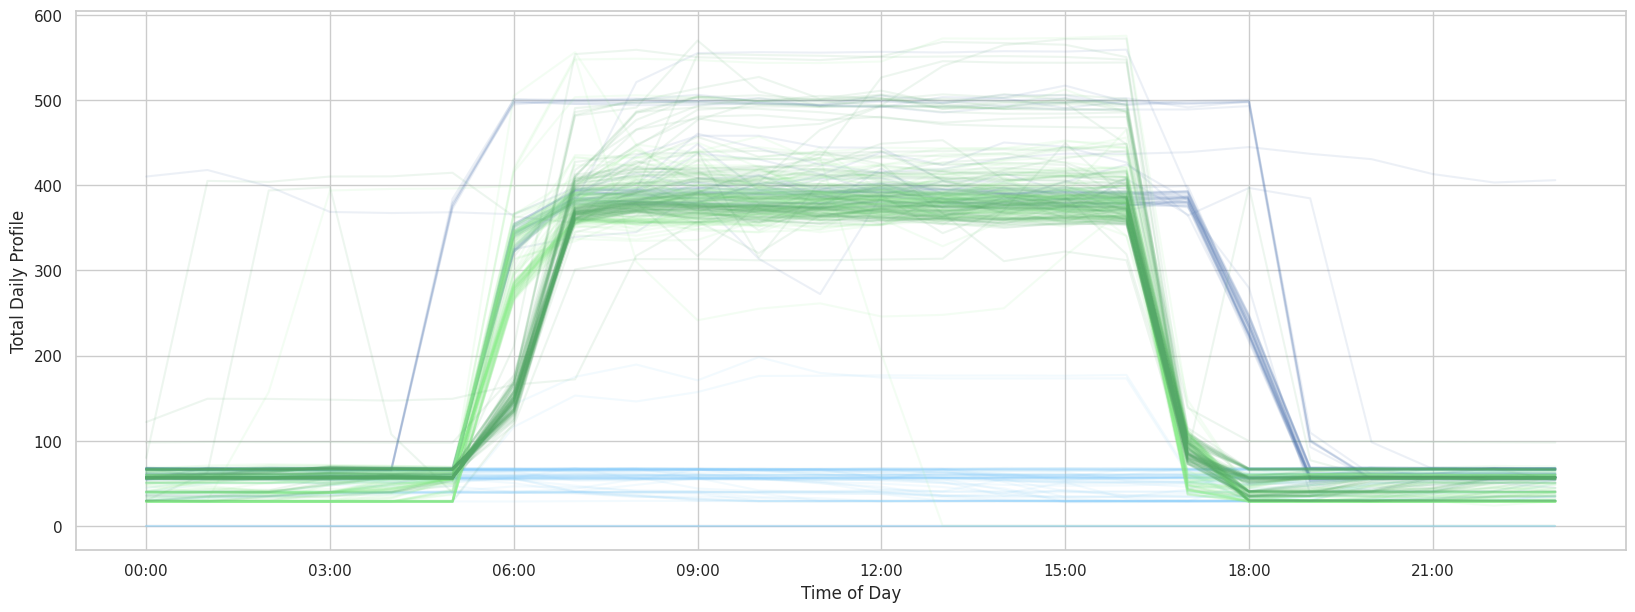

In [57]:
clusterlist = list(dailyclusters_pivot.columns.get_level_values(0).unique())
matplotlib.rcParams['figure.figsize'] = 20, 7

styles2 = ['LightSkyBlue', 'b','LightGreen', 'g','LightCoral','r','SandyBrown','Orange','Plum','Purple','Gold','b']
fig, ax = plt.subplots()
for col, style in zip(clusterlist, styles2):
    dailyclusters_pivot[col].plot(ax=ax, legend=False, style=style, alpha=0.1, xticks=np.arange(0, 86400, 10800))



ax.set_ylabel('Total Daily Profile')
ax.set_xlabel('Time of Day')
plt.savefig("clusters_total_overlaid_profiles.png")
plt.show()     


In [58]:
from datetime import datetime

def ClusterUnstacker(melted_motifs):
    melted_motifs = melted_motifs.unstack().reset_index()
    melted_motifs['timestampstring'] = list(map(timestampcombine, melted_motifs['Date'], melted_motifs['Time']))
    melted_motifs = melted_motifs.dropna()
    return melted_motifs


In [59]:
def timestampcombine(date,time):
    pydatetime = datetime.combine(date, time)
    #pydatetime = pydatetime.replace(tzinfo=pytz.UTC)
    #return pydatetime.astimezone(singaporezone).replace(tzinfo=None)
    return pydatetime

In [60]:
dailyclusters_pivot.index.name = 'Time'
dailyclusters_pivot.head()

ClusterNo2          0                                                         \
Date       2021-01-01 2021-01-02 2021-01-03 2021-01-09 2021-01-10 2021-01-16   
Time                                                                           
00:00:00       53.937     54.990     53.815     65.797     66.536     65.760   
01:00:00       54.041     55.051     60.743     65.933     65.514     65.688   
02:00:00       53.816     54.279     64.986     65.059     65.510     65.961   
03:00:00       53.573     53.978     53.698     65.352     65.686     65.799   
04:00:00       53.940     53.812     53.294     65.641     65.888     66.295   

ClusterNo2                                              ...          2  \
Date       2021-01-17 2021-01-23 2021-01-24 2021-01-30  ... 2021-05-28   
Time                                                    ...              
00:00:00       66.795     65.565     65.358     54.992  ...     56.627   
01:00:00       66.901     64.304     64.353     59.668  ...     57.167   
02:00:00       65.933     64.339     64.267     65.340  ...     56.658   
03:00:00       65.515     63.878     64.450     64.596  ...     57.571   
04:00:00       65.674     64.505     65.388     65.355  ...     56.630   

ClusterNo2                                                                    \
Date       2021-05-31 2021-06-01 2021-06-02 2021-06-03 2021-06-04 2021-06-16   
Time                                                                           
00:00:00       34.665     29.344     29.596     29.451     29.330     29.638   
01:00:00       35.694     34.036     29.305     28.850     28.796     62.421   
02:00:00       39.650     35.050     31.330     29.010     34.601    393.857   
03:00:00       48.510     40.242     34.694     28.891     39.356    397.715   
04:00:00       57.270     39.769     39.096     28.930     39.158    107.459   

ClusterNo2                                   
Date       2021-06-21 2021-07-26 2021-10-12  
Time                                         
00:00:00       79.749    121.816     51.087  
01:00:00      405.105    149.188     51.230  
02:00:00      403.996    149.012     56.759  
03:00:00      410.239    148.068     58.230  
04:00:00      410.471    147.055     56.332  

[5 rows x 329 columns]

In [61]:
dfclusterunstacked = ClusterUnstacker(dailyclusters_pivot)

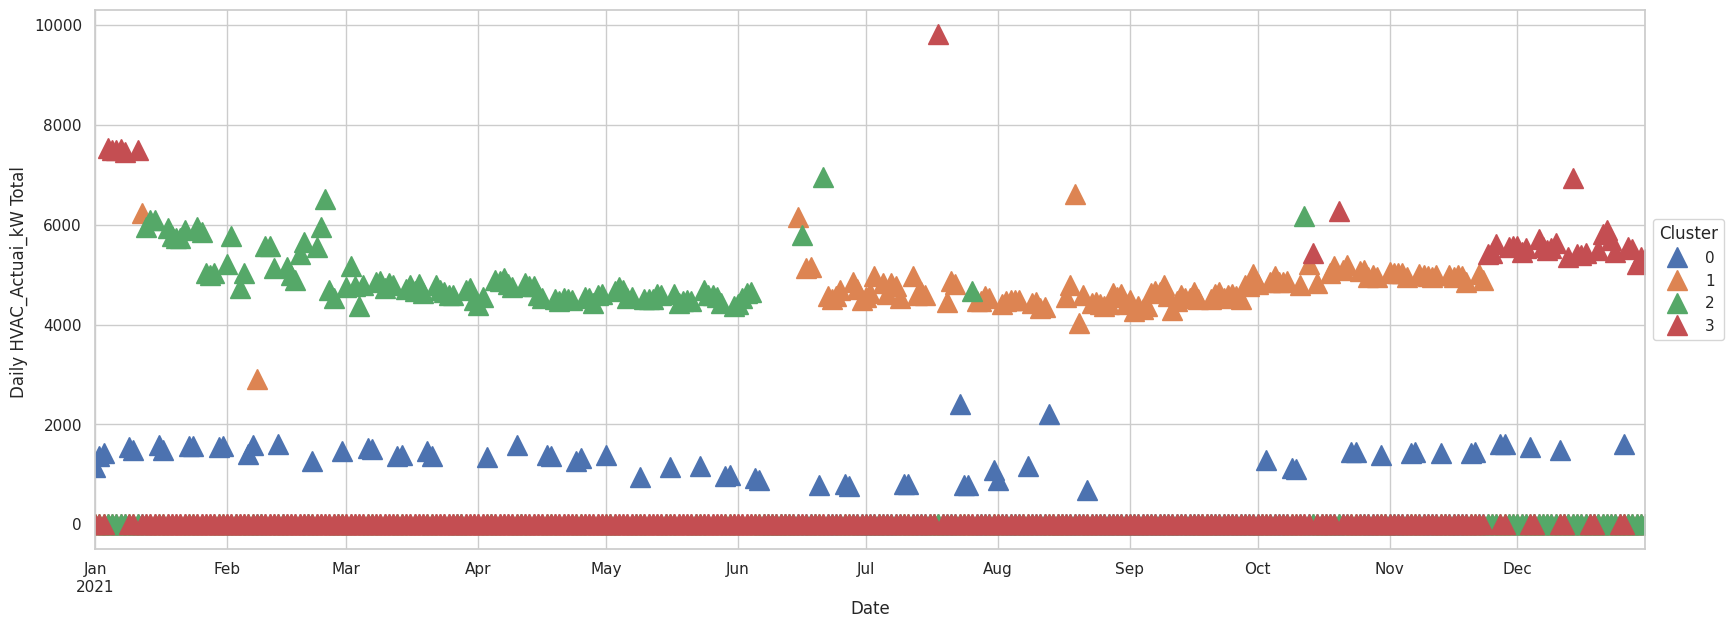

In [62]:

dfclusterunstackedpivoted = pd.pivot_table(dfclusterunstacked, values=0, index='timestampstring', columns='ClusterNo2')

clusteravgplot = dfclusterunstackedpivoted.resample('D').sum().plot(style="^",markersize=15)
clusteravgplot.set_ylabel('Daily HVAC_Actuai_kW Total ')
clusteravgplot.set_xlabel('Date')
clusteravgplot.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')

plt.savefig("clusters_overtime.png")

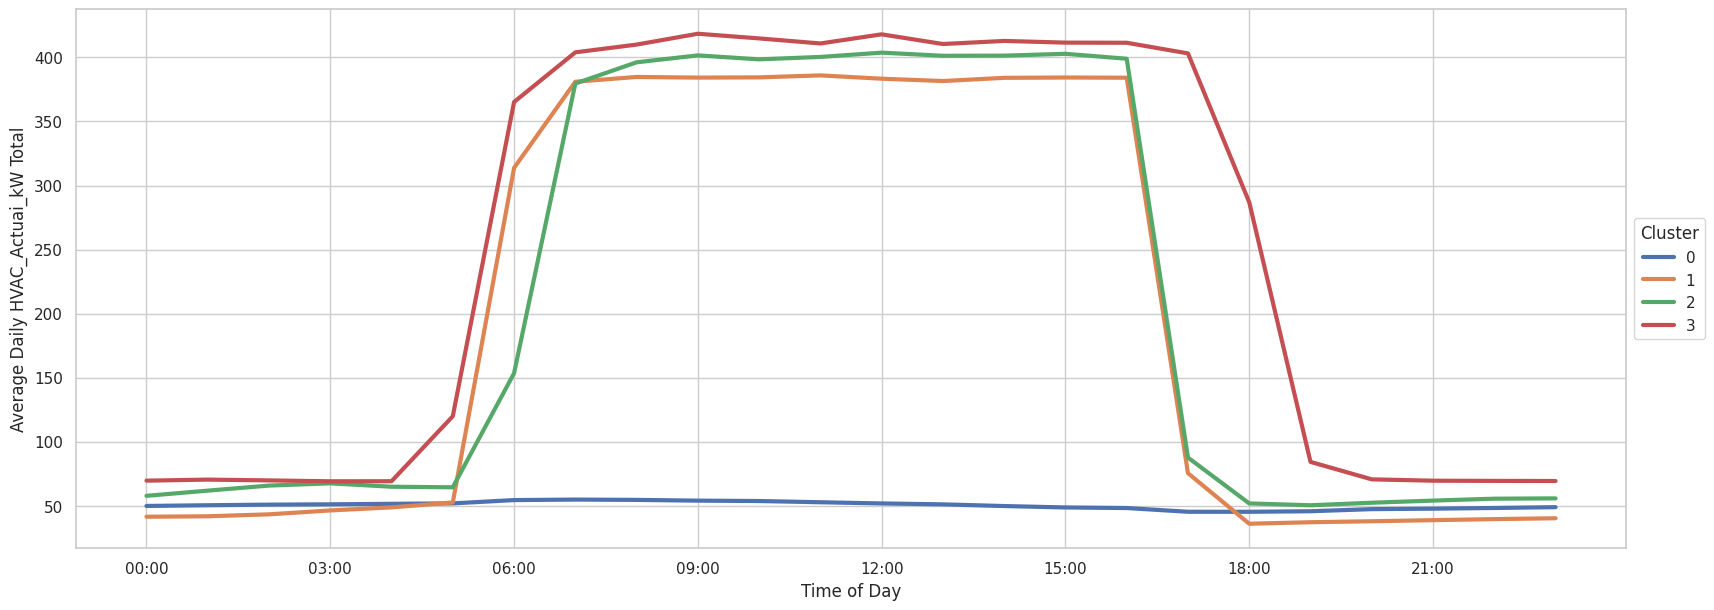

In [63]:
dfclusterunstackedpivoted['Time'] = dfclusterunstackedpivoted.index.map(lambda t: t.time())
dailyprofile = dfclusterunstackedpivoted.groupby('Time').mean().plot(figsize=(20,7),linewidth=3, xticks=np.arange(0, 86400, 10800))
dailyprofile.set_ylabel('Average Daily HVAC_Actuai_kW Total')
dailyprofile.set_xlabel('Time of Day')
dailyprofile.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
plt.savefig("clusters_averagedprofiles.png")

In [64]:
df = melted_motifs
def DayvsClusterMaker(df):
    df.index = df.timestampstring
    df['Weekday'] = df.index.map(lambda t: t.date().weekday())
    df['Date'] = df.index.map(lambda t: t.date())
    df['Time'] = df.index.map(lambda t: t.time())

    time_column = df['Time']
    
    df = df.drop('Time', axis=1)

    DayVsCluster = df.groupby('Date').mean()
    DayVsCluster = pd.pivot_table(DayVsCluster, values=0, index='ClusterNo2', columns='Weekday', aggfunc='count')
    DayVsCluster.columns = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
    

    DayVsCluster['Time'] = time_column
    
    return DayVsCluster.T



In [65]:
DayVsCluster = DayvsClusterMaker(dfclusterunstacked)

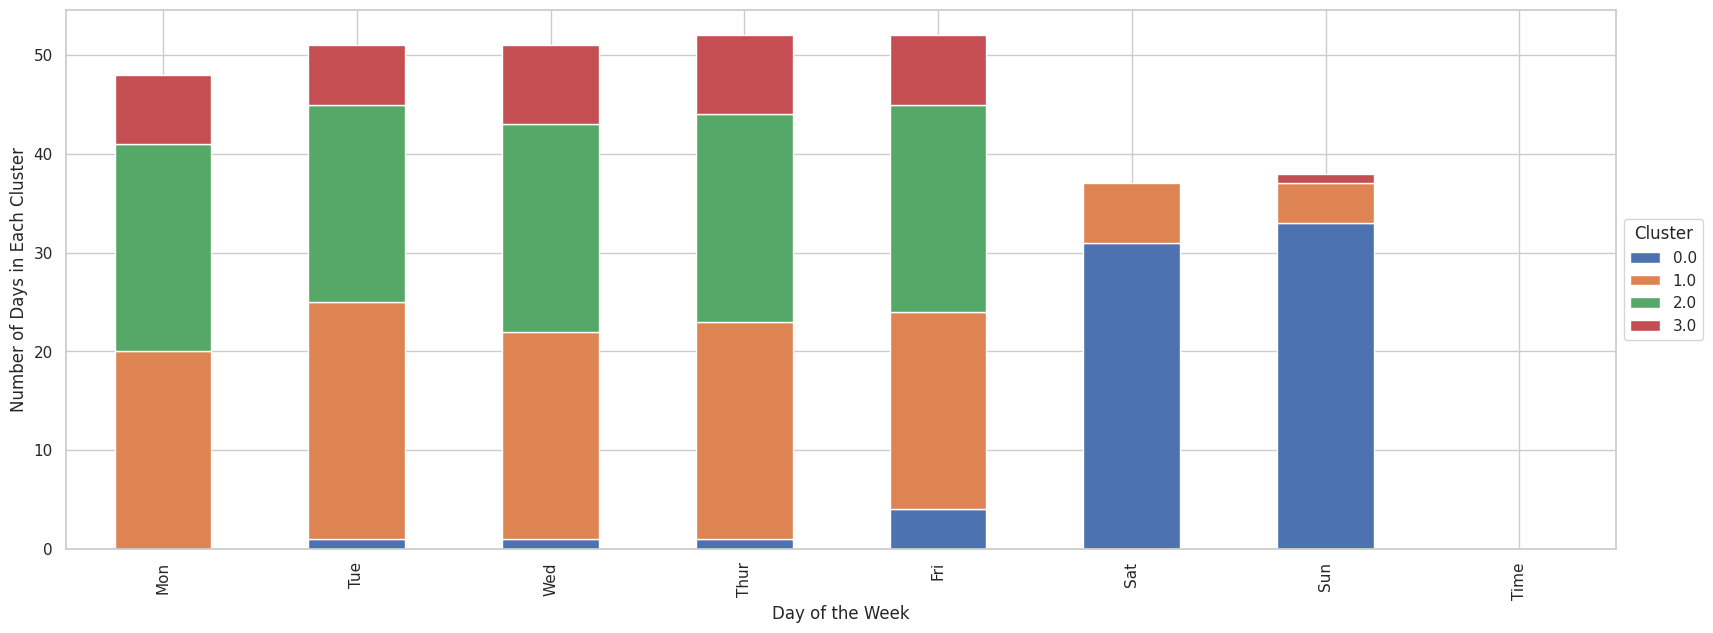

In [66]:

DayVsClusterplot1 = DayVsCluster.plot(figsize=(20,7),kind='bar',stacked=True)
DayVsClusterplot1.set_ylabel('Number of Days in Each Cluster')
DayVsClusterplot1.set_xlabel('Day of the Week')
DayVsClusterplot1.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
plt.savefig("clusters_dailybreakdown.png")

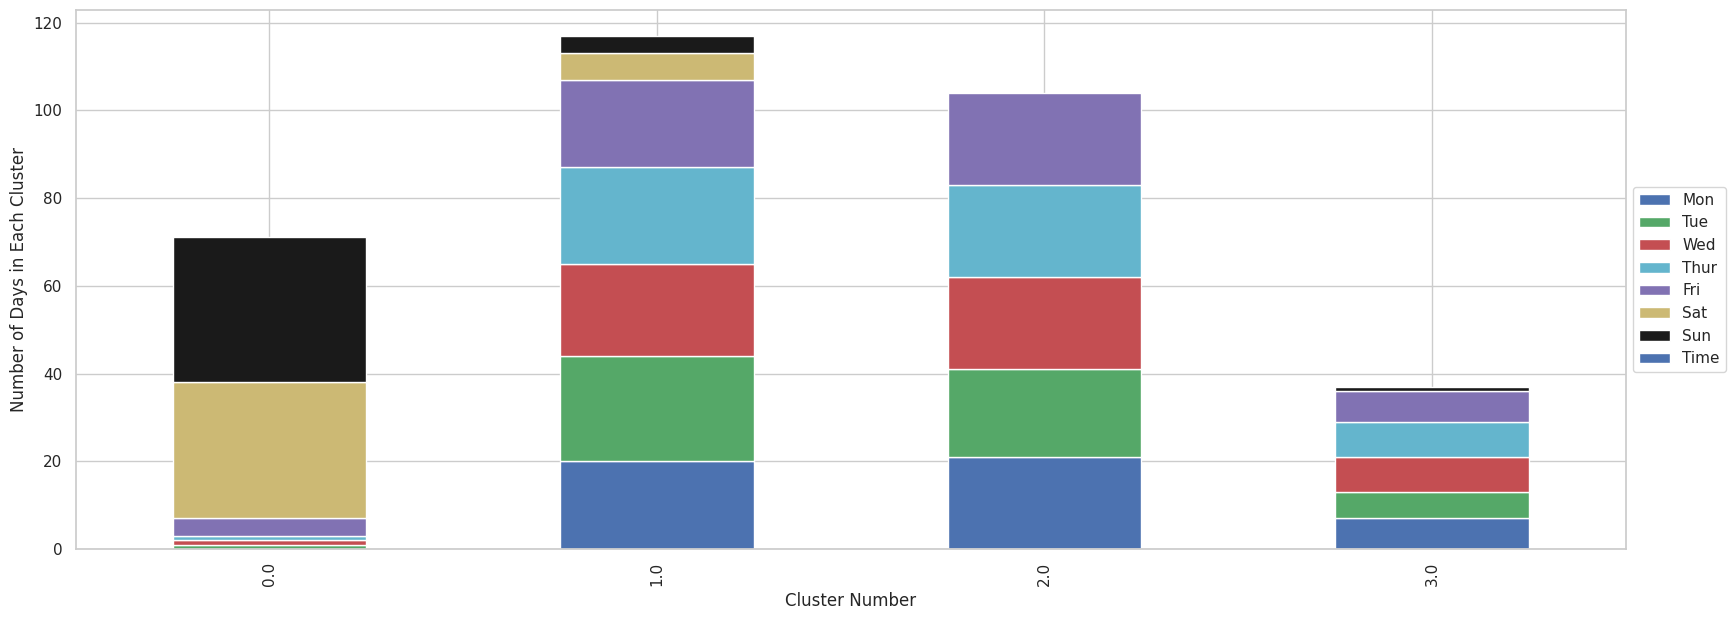

In [67]:
DayVsClusterplot2 = DayVsCluster.T.plot(figsize=(20,7),kind='bar',stacked=True, color=['b','g','r','c','m','y','k']) #, color=colors2
DayVsClusterplot2.set_ylabel('Number of Days in Each Cluster')
DayVsClusterplot2.set_xlabel('Cluster Number')
DayVsClusterplot2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("cluster_numberofdays.png")